# Demo de implementación de un Algoritmo Genético para resolver el problema de encontrar un vector lleno de 1s ("One Max Problem")
Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

0) Preparar el ambiente:

In [1]:
#@title
!pip install deap

     |████████████████████████████████| 163kB 5.6MB/s 


1) Importar librerías:

In [2]:
#@title
import random
import numpy as np
import matplotlib.pyplot as plt

from deap import base
from deap import creator
from deap import tools

print("\nLibrerías importadas")


Librerías importadas


2) Inicializar objetos de DEAP para utilizar e indicar Operadores Genéticos:

In [3]:
#@title Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

## OPERADORES GENÉTICOS
## (ver lista completa en https://deap.readthedocs.io/en/master/api/tools.html#operators )

# Registrar tipo de Selección a aplicar con sus parámetros
toolbox.register("select", tools.selTournament, tournsize=2)

# Registrar tipo de Cruzamiento a aplicar con sus parámetros
toolbox.register("mate", tools.cxTwoPoint)

# Registrar tipo de Mutación a aplicar con sus parámetros
toolbox.register("mutate", tools.mutFlipBit, indpb=0.5)

print("\nOperadores Genéticos definidos")


Operadores Genéticos definidos


3) Especificar Estructura del Cromosoma y Función de Aptitud:

In [4]:
#@title FUNCIÓN DE APTITUD

# indica que es la función de aptitud es para maximizar
creator.create("Fitness", base.Fitness, weights=(1.0,))

# definimos la función de aptitud
def funcAptitud(individual):
    return sum(individual),

    
# registra la función que se va a evaluar
toolbox.register("evaluate", funcAptitud)

print("\nFunción de Aptitud definida")


Función de Aptitud definida


In [5]:
#@title ESTRUCTURA DEL CROMOSOMA

# indica que los individuos son una lista de genes que aplica la función antes definida
creator.create("Individual", list, fitness=creator.Fitness)

# indica que los genes son binarios ( 0 / 1 )
toolbox.register("attr_bin", random.randint, 0, 1)

# cantidad de genes que va a tener el cromosoma
cant_genesCromosoma = 10

# registra el tipo de individuo y población a usar
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bin, cant_genesCromosoma)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

print("\nCromosoma definido")


Cromosoma definido


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [6]:
#@title
### Parámetros de la Corrida

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 100  #@param {type:"integer"}

# Indica que finaliza corrida cuando se alcance una  Aptitud Mínima (opcional)
FINALIZA_CORRIDA_POR_MIN_APTITUD = True  #@param {type:"boolean"}
FINALIZA_CORRIDA_VAL_MIN_APTITUD = 10  #@param {type:"integer"}

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 3  #@param {type:"integer"}

# Probabilidad del Cruzamiento (en AG 1 = 100%)
PROBAB_CRUZAMIENTO = 1 

# Probabilidad del Mutación 
PROBAB_MUTACION = 0.3 #@param {type:"slider", min:0, max:1, step:0.05}

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True  #@param {type:"boolean"}

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


In [7]:
#@title EJECUCIÓN DE LA CORRIDA


## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra, mejorMax = True):
    
    global mejorIndCorrida
    global ciclosMaxAptitud
    global ciclosPromAptitud
    global ciclosMinAptitud

    if len(indivPobla) == 0:
      return None, 0, 0, 0 

    auxMax = None
    auxMin = None
    auxSum = 0
    auxBestInd = None
    auxBestIndApt = None
    
    for ind in indivPobla:

        apt = round(ind.fitness.values[0], 2)
        auxSum = auxSum + apt

        if (auxMax == None) or (apt > auxMax):
            auxMax = apt
            if mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt

        if (auxMin == None) or (apt < auxMin):
            auxMin = apt
            if not mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt

    auxProm = round(auxSum / len(indivPobla),2)

    ciclosMaxIndiv.append( auxBestInd )
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )

    if muestra:          
        print("\n-- Ciclo  %i --" % ciclo)
        print(" Mejor Individuo:", auxBestInd, " {", auxBestIndApt, "}")
        print("   Max: ", auxMax, " / Promedio: ", auxProm, " / Min: ", auxMin)

    return auxBestInd, auxMax, auxProm, auxMin

# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)

# Asigna el valor de aptitud a los individuos de la población inicial
fitnesses = list(map(toolbox.evaluate, indivPobla))
for ind, fit in zip(indivPobla, fitnesses):
    ind.fitness.values = fit

# vectores auxiliares 
ciclo = 1    
ciclosMaxIndiv = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []

# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS)
      
        # criterio de paro
while (ciclo < CANT_CICLOS) and (not(FINALIZA_CORRIDA_POR_MIN_APTITUD) or (auxMax < FINALIZA_CORRIDA_VAL_MIN_APTITUD)):

    # Realiza la Selección
    indivSelecc = toolbox.select(indivPobla, len(indivPobla))

    # Inicializa a los hijos clonando a los seleccionados
    indivHijos = list(map(toolbox.clone, indivSelecc))
    
    # Realiza el Cruzamiento
    for hijo1, hijo2 in zip(indivHijos[::2], indivHijos[1::2]):
        if random.random() < PROBAB_CRUZAMIENTO:
            toolbox.mate(hijo1, hijo2)
            del hijo1.fitness.values
            del hijo2.fitness.values

    # Realiza la Mutación
    for mutant in indivHijos:
        if random.random() < PROBAB_MUTACION:
            toolbox.mutate(mutant)
            del mutant.fitness.values
              
    # Evalua a los individuos que salen de la Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivHijos if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    # Reemplaza la población actual con los hijos
    indivPobla[:] = indivHijos
    
    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS)


    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --" % ciclo )

mejorCiclo = np.argmax( ciclosMaxAptitud )
print("\n== Mejor Individuo de la Corrida:", ciclosMaxIndiv[mejorCiclo], " { ", ciclosMaxAptitud[mejorCiclo], " } ==")


-- Ciclo  0 --
 Mejor Individuo: [0, 0, 1, 1, 1, 1, 1, 0, 0, 1]  { 6.0 }
   Max:  6.0  / Promedio:  5.33  / Min:  4.0

-- Ciclo  1 --
 Mejor Individuo: [1, 1, 0, 0, 1, 0, 1, 0, 1, 1]  { 6.0 }
   Max:  6.0  / Promedio:  4.67  / Min:  3.0

-- Ciclo  2 --
 Mejor Individuo: [1, 1, 1, 1, 1, 0, 1, 0, 1, 1]  { 8.0 }
   Max:  8.0  / Promedio:  6.0  / Min:  5.0

-- Ciclo  3 --
 Mejor Individuo: [1, 1, 1, 0, 1, 0, 0, 0, 1, 0]  { 5.0 }
   Max:  5.0  / Promedio:  4.67  / Min:  4.0

-- Ciclo  4 --
 Mejor Individuo: [0, 1, 0, 1, 1, 1, 0, 0, 1, 1]  { 6.0 }
   Max:  6.0  / Promedio:  4.67  / Min:  4.0

-- Ciclo  5 --
 Mejor Individuo: [0, 1, 0, 1, 1, 1, 0, 0, 1, 1]  { 6.0 }
   Max:  6.0  / Promedio:  4.67  / Min:  2.0

-- Ciclo  6 --
 Mejor Individuo: [1, 1, 0, 1, 1, 0, 1, 0, 1, 1]  { 7.0 }
   Max:  7.0  / Promedio:  6.33  / Min:  6.0

-- Ciclo  7 --
 Mejor Individuo: [1, 1, 0, 1, 1, 0, 1, 0, 1, 1]  { 7.0 }
   Max:  7.0  / Promedio:  7.0  / Min:  7.0

-- Ciclo  8 --
 Mejor Individuo: [1, 1, 0, 1, 1, 

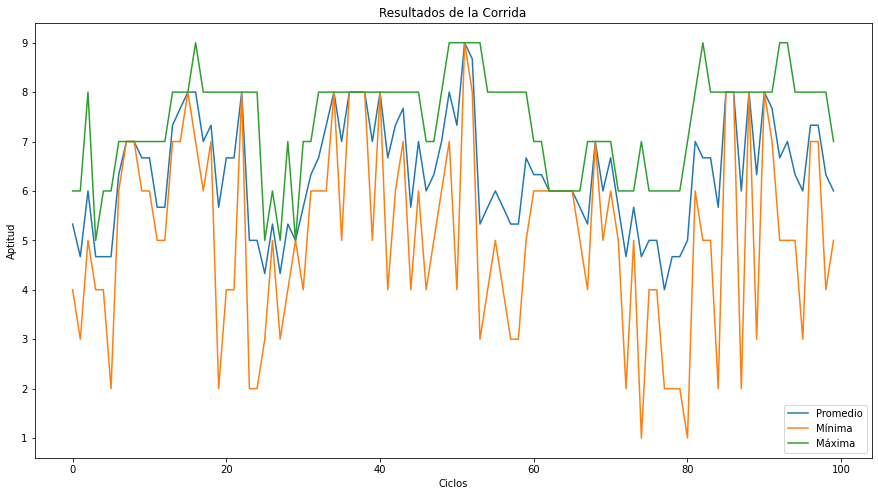

In [8]:
#@title MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8)) 
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMinAptitud)
plt.plot(ciclosMaxAptitud)

plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud')
plt.legend(['Promedio', 'Mínima', 'Máxima'], loc='lower right')

plt.show()